In [2]:
import pandas as pd

In [3]:
data=pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M',flavor='bs4')

In [4]:
df=pd.DataFrame()

In [5]:
df=data[0]
df.head()

,0,1,2
0,Postcode,Borough,Neighbourhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village


In [6]:
headers=['Postcode','Borough','Neighbourhood']
df.columns=headers

In [8]:
df.drop(df.index[0],inplace=True)
df.head()

,Postcode,Borough,Neighbourhood
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront
6,M5A,Downtown Toronto,Regent Park


In [9]:
df=df[df.Borough!='Not assigned']
df.head()

,Postcode,Borough,Neighbourhood
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront
6,M5A,Downtown Toronto,Regent Park
7,M6A,North York,Lawrence Heights


In [ ]:
df.loc[df['Neighbourhood']=='Not assigned','Neighbourhood']=df['Borough']

In [11]:
df = df.groupby('Postcode').agg({ 
                             'Neighbourhood': ', '.join, 
                             'Borough':'first' }).reset_index()
df.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [12]:
df_val=pd.read_csv('https://cocl.us/Geospatial_data')

In [13]:
df_val.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [14]:
df=pd.concat([df,df_val],axis=1)

In [15]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium


Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.3.1               |             py_0          25 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    altair-2.2.2               |           py35_1         462 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2019.3.9   |       hecc5488_0         146 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.0 MB

The following NEW packages will

In [16]:
CLIENT_ID = 'TFYTFBU5SXHMMWVZIGMXPD5QUEC52OSTEAY0YKKWLLOMLIFH' # your Foursquare ID
CLIENT_SECRET = 'ZDBXDPFLQZT2PJ2FPLSMYZMNYDDIZSASI43IRJ1DN4PTYB41' # your Foursquare Secret
VERSION = '20190511' # Foursquare API version



In [17]:
LATITUDE=43.662760
LONGITUDE=-79.397310

In [18]:
LIMIT=100
radius=500
url='https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,VERSION,LATITUDE,LONGITUDE,radius,LIMIT)



In [19]:
import requests
import json
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans


In [19]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5cd8411b4c1f6743900693d5'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4ce47a4bc850721e2b8bc38a-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/performingarts_theater_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d137941735',
         'name': 'Theater',
         'pluralName': 'Theaters',
         'primary': True,
         'shortName': 'Theater'}],
       'id': '4ce47a4bc850721e2b8bc38a',
       'location': {'address': '7 Hart House Cir.',
        'cc': 'CA',
        'city': 'Toronto',
        'country': 'Canada',
        'crossStreet': 'University of Toronto',
        'distance': 234,
        'formattedAddress': ['7 Hart House Cir. (University of Toronto)',
         'Toronto ON M5S 3H3',
       

In [20]:
# function that extracts the name of the venue
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [21]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()


,name,categories,lat,lng
0,Hart House Theatre,Theater,43.663571,-79.394616
1,Queen's Park,Park,43.663946,-79.392180
2,Yasu,Japanese Restaurant,43.662837,-79.403217
3,Philosopher's Walk,Park,43.666894,-79.395597
4,Piano Piano,Italian Restaurant,43.662949,-79.402898


In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
toronto_venues = getNearbyVenues(names=df['Borough'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )



Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
Scarborough
North York
North York
North York
North York
North York
North York
North York
North York
North York
North York
North York
North York
North York
North York
North York
North York
North York
North York
East York
East York
East Toronto
East York
East York
East York
East Toronto
East Toronto
East Toronto
Central Toronto
Central Toronto
Central Toronto
Central Toronto
Central Toronto
Central Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
North York
Central Toronto
Central Toronto
Central Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
Downtown Toronto
North York
North York
York
York
Downtown Toronto
Wes

In [25]:
print(toronto_venues.shape)
toronto_venues.head()

(2243, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Scarborough,43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,Scarborough,43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,Scarborough,43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,Scarborough,43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,Scarborough,43.763573,-79.188711,Marina Spa,43.766000,-79.191000,Spa


In [26]:
toronto_venues.groupby('Borough').count()

,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Borough,,,,,,
Central Toronto,109,109,109,109,109,109
Downtown Toronto,1287,1287,1287,1287,1287,1287
East Toronto,124,124,124,124,124,124
East York,74,74,74,74,74,74
Etobicoke,72,72,72,72,72,72
Mississauga,10,10,10,10,10,10
North York,243,243,243,243,243,243
Queen's Park,39,39,39,39,39,39
Scarborough,85,85,85,85,85,85


In [27]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 274 uniques categories.


In [28]:
Categories = toronto_venues['Venue Category'].unique()
Categories.sort()
print(Categories)

['Accessories Store' 'Adult Boutique' 'Afghan Restaurant' 'Airport'
 'Airport Food Court' 'Airport Gate' 'Airport Lounge' 'Airport Service'
 'Airport Terminal' 'American Restaurant' 'Antique Shop' 'Aquarium'
 'Arcade' 'Argentinian Restaurant' 'Art Gallery' 'Art Museum'
 'Arts & Crafts Store' 'Asian Restaurant' 'Athletics & Sports'
 'Auto Garage' 'Auto Workshop' 'BBQ Joint' 'Baby Store' 'Bagel Shop'
 'Bakery' 'Bank' 'Bar' 'Baseball Field' 'Baseball Stadium'
 'Basketball Stadium' 'Beach' 'Bed & Breakfast' 'Beer Bar' 'Beer Store'
 'Belgian Restaurant' 'Bike Shop' 'Bistro' 'Boat or Ferry' 'Bookstore'
 'Boutique' 'Brazilian Restaurant' 'Breakfast Spot' 'Brewery' 'Bridal Shop'
 'Bubble Tea Shop' 'Burger Joint' 'Burrito Place' 'Bus Line' 'Bus Station'
 'Business Service' 'Butcher' 'Cafeteria' 'Café'
 'Cajun / Creole Restaurant' 'Camera Store' 'Candy Store'
 'Caribbean Restaurant' 'Cheese Shop' 'Chinese Restaurant' 'Chocolate Shop'
 'Church' 'Climbing Gym' 'Clothing Store' 'Cocktail Bar' 'Coff

In [29]:
toronto_rest=toronto_venues[(toronto_venues['Venue Category'].str.contains('Restaurant'))]        

In [30]:
toronto_rest.head()

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Scarborough,43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
5,Scarborough,43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant
12,Scarborough,43.770992,-79.216917,Korean Grill House,43.770812,-79.214502,Korean Restaurant
14,Scarborough,43.773136,-79.239476,Federick Restaurant,43.774697,-79.241142,Hakka Restaurant
15,Scarborough,43.773136,-79.239476,Drupati's Roti & Doubles,43.775222,-79.241678,Caribbean Restaurant


In [113]:
value=toronto_rest['Borough'].value_counts()
value_df = pd.DataFrame({'Borough':value.index, 'Count':value.values})


In [84]:
value_df.sort_values('Borough',inplace=True)



In [86]:
value_df.reset_index(inplace=True)

In [91]:
value_df.drop('index',axis=1,inplace=True)

In [92]:
value_df

,Borough,Count
0,Central Toronto,20
1,Downtown Toronto,311
2,East Toronto,30
3,East York,8
4,Etobicoke,9
5,Mississauga,2
6,North York,60
7,Queen's Park,9
8,Scarborough,23
9,West Toronto,45


In [93]:
tor_rest_bar = toronto_rest.groupby('Borough').agg({ 
                             'Venue Category': ', '.join, 
                             'Borough Latitude':'first', 
                              'Borough Longitude' :'first', 'Venue': ', '.join, 'Venue Latitude':'first','Venue Longitude': 'first'       }).reset_index()


In [94]:
tor_rest_bar.head()

,Borough,Venue Category,Borough Longitude,Venue,Venue Latitude,Borough Latitude,Venue Longitude
0,Central Toronto,"Mexican Restaurant, Chinese Restaurant, Fast F...",-79.405678,"Tio's Urban Mexican, C'est Bon, A&W, Marigold ...",43.714630,43.715383,-79.400000
1,Downtown Toronto,"Indian Restaurant, Italian Restaurant, Japanes...",-79.367675,"Butter Chicken Factory, F'Amelia, Kingyo Toron...",43.667072,43.667967,-79.369184
2,East Toronto,"Greek Restaurant, Italian Restaurant, Greek Re...",-79.352188,"Pantheon, Cafe Fiorentina, Mezes, Messini Auth...",43.677621,43.679557,-79.351434
3,East York,"Fast Food Restaurant, Fast Food Restaurant, As...",-79.309937,"Harvey's, Harvey's, Thai Wok, The Leaside Pub,...",43.710730,43.706397,-79.308838
4,Etobicoke,"Restaurant, Fast Food Restaurant, Seafood Rest...",-79.501321,"New Toronto Fish & Chips, McDonald's, Halibut ...",43.601849,43.605647,-79.503281


In [95]:
tor_rest_bar=pd.concat([tor_rest_bar,value_df],axis=1)

In [104]:
tor_rest_bar = tor_rest_bar.loc[:,~tor_rest_bar.columns.duplicated()]

In [105]:
tor_rest_bar

,Borough,Venue Category,Borough Longitude,Venue,Venue Latitude,Borough Latitude,Venue Longitude,Count
0,Central Toronto,"Mexican Restaurant, Chinese Restaurant, Fast F...",-79.405678,"Tio's Urban Mexican, C'est Bon, A&W, Marigold ...",43.714630,43.715383,-79.400000,20
1,Downtown Toronto,"Indian Restaurant, Italian Restaurant, Japanes...",-79.367675,"Butter Chicken Factory, F'Amelia, Kingyo Toron...",43.667072,43.667967,-79.369184,311
2,East Toronto,"Greek Restaurant, Italian Restaurant, Greek Re...",-79.352188,"Pantheon, Cafe Fiorentina, Mezes, Messini Auth...",43.677621,43.679557,-79.351434,30
3,East York,"Fast Food Restaurant, Fast Food Restaurant, As...",-79.309937,"Harvey's, Harvey's, Thai Wok, The Leaside Pub,...",43.710730,43.706397,-79.308838,8
4,Etobicoke,"Restaurant, Fast Food Restaurant, Seafood Rest...",-79.501321,"New Toronto Fish & Chips, McDonald's, Halibut ...",43.601849,43.605647,-79.503281,9
5,Mississauga,"American Restaurant, Mediterranean Restaurant",-79.615819,"Great North American Grill, Anoush",43.638429,43.636966,-79.618756,2
6,North York,"Fast Food Restaurant, Mediterranean Restaurant...",-79.363452,"New York Fries, Villa Madina, Moxie's Classic ...",43.803664,43.803762,-79.363905,60
7,Queen's Park,"Italian Restaurant, Portuguese Restaurant, Sus...",-79.389494,"Mercatto, Nando's Flame-Grilled Chicken, Tokyo...",43.660391,43.662301,-79.387664,9
8,Scarborough,"Fast Food Restaurant, Mexican Restaurant, Kore...",-79.194353,"Wendy's, Big Bite Burrito, Korean Grill House,...",43.807448,43.806686,-79.199056,23
9,West Toronto,"Middle Eastern Restaurant, Fast Food Restauran...",-79.442259,"Parallel, McDonald's, Stop BBQ Chicken, OddSeo...",43.669516,43.669005,-79.438728,45


In [118]:
df_map=tor_rest_bar[['Borough','Count']]
df_map

,Borough,Count
0,Central Toronto,20
1,Downtown Toronto,311
2,East Toronto,30
3,East York,8
4,Etobicoke,9
5,Mississauga,2
6,North York,60
7,Queen's Park,9
8,Scarborough,23
9,West Toronto,45


In [111]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt


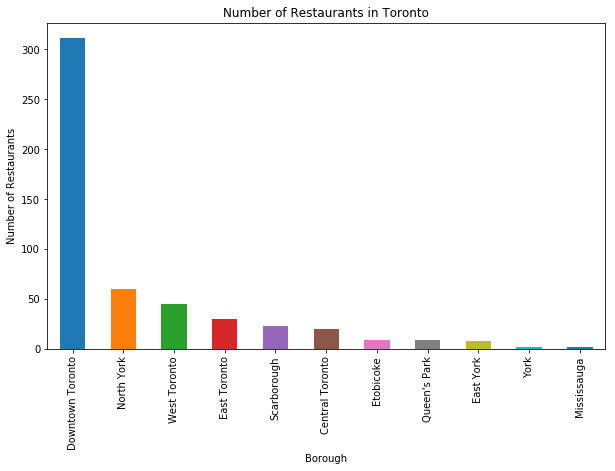

In [112]:
value.plot(kind='bar', figsize=(10,6))
plt.xlabel('Borough')
plt.ylabel('Number of Restaurants')
plt.title('Number of Restaurants in Toronto')
plt.show()

In [114]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[43.662760, -79.397310], zoom_start=10)

# add markers to map
for lat, lng, borough  in zip(tor_rest_bar['Borough Latitude'], tor_rest_bar['Borough Longitude'], tor_rest_bar['Borough'], ):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [154]:
toronto_onehot = pd.get_dummies(toronto_rest[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot['Venue Latitude'] = toronto_rest['Venue Latitude']
toronto_onehot['Venue Longitude'] = toronto_rest['Venue Longitude']
toronto_onehot['Borough Longitude'] = toronto_rest['Borough Longitude']
toronto_onehot['Borough Latitude'] = toronto_rest['Borough Latitude']
toronto_onehot.head()

,Afghan Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,...,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Venue Latitude,Venue Longitude,Borough Longitude,Borough Latitude
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,43.807448,-79.199056,-79.194353,43.806686
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,43.766299,-79.190720,-79.188711,43.763573
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,43.770812,-79.214502,-79.216917,43.770992
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,43.774697,-79.241142,-79.239476,43.773136
15,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,43.775222,-79.241678,-79.239476,43.773136


In [155]:
kclusters = 7

toronto_cluster=toronto_onehot

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([6, 2, 2, 2, 2, 5, 6, 1, 2, 2, 2, 2, 2, 2, 2, 3, 5, 6, 2, 2, 6, 6, 0,
       6, 2, 1, 6, 0, 4, 6, 6, 2, 6, 4, 2, 0, 6, 2, 0, 2, 2, 0, 4, 2, 2, 2,
       4, 6, 2, 2, 2, 6, 2, 0, 3, 4, 0, 2, 2, 2, 6, 2, 4, 2, 6, 2, 2, 2, 2,
       6, 6, 2, 4, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 4, 2, 2, 2, 2, 2, 2, 0, 1,
       2, 3, 2, 6, 2, 2, 3, 2, 5, 1, 3, 1, 2, 2, 2, 6, 2, 5, 3, 2, 3, 5, 2,
       2, 4, 1, 2, 2, 2, 3, 0, 4, 2, 2, 5, 4, 3, 1, 2, 2, 2, 4, 2, 0, 2, 0,
       2, 2, 3, 4, 2, 0, 2, 2, 5, 2, 6, 2, 4, 1, 0, 2, 2, 0, 2, 0, 6, 2, 4,
       2, 5, 2, 3, 2, 5, 5, 1, 0, 2, 2, 2, 2, 4, 3, 2, 6, 2, 2, 3, 5, 2, 4,
       2, 6, 2, 2, 0, 0, 3, 4, 2, 0, 4, 1, 2, 5, 2, 4, 3, 2, 2, 5, 2, 4, 5,
       5, 1, 2, 5, 4, 6, 3, 5, 5, 5, 5, 5, 3, 2, 2, 4, 2, 4, 3, 2, 2, 2, 3,
       2, 5, 0, 5, 2, 5, 2, 2, 1, 2, 2, 2, 2, 3, 2, 5, 2, 3, 0, 2, 4, 2, 4,
       5, 2, 2, 5, 2, 1, 2, 1, 2, 1, 2, 0, 5, 1, 4, 2, 2, 4, 2, 2, 2, 5, 5,
       3, 0, 2, 5, 2, 3, 0, 2, 2, 4, 2, 5, 3, 4, 5, 3, 3, 4, 6, 4, 0, 1, 2,
       4, 4,

In [156]:
# add clustering labels
toronto_onehot.insert(0, 'Cluster Labels', kmeans.labels_)





In [157]:
import numpy as np

In [158]:
# create map
map_clusters = folium.Map(location=[LATITUDE,LONGITUDE], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(toronto_onehot['Venue Latitude'], toronto_onehot['Venue Longitude'], toronto_onehot['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters